In [30]:
import sys
import numpy as np
import pandas as pd

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
#Importing merged datasets from google drive

user = pd.read_csv('/content/drive/MyDrive/Rumor Detection/new Dataset/train/user (1).csv')
tweet = pd.read_csv('/content/drive/MyDrive/Rumor Detection/new Dataset/train/tweet (1).csv')

In [33]:
user.head()

,userId,name,screen_name,tweetId,verfifed,followers_count,statuses_count,friends_count,favourites_count,listed_count,location,created_at,profile_image_url,profile_background_image_url,default_profile_image,default_profile,profile_use_background_image,url
0,14075928,The Onion,TheOnion,273182568298450945,True,11758300,80911,7,3,68775,NaN,2008-03-04 02:48:37,http://pbs.twimg.com/profile_images/8753920681...,http://abs.twimg.com/images/themes/theme3/bg.gif,False,False,True,https://t.co/EIF811CxOS
1,14075928,The Onion,TheOnion,273278761909239808,True,11758329,80911,7,3,68775,NaN,2008-03-04 02:48:37,http://pbs.twimg.com/profile_images/8753920681...,http://abs.twimg.com/images/themes/theme3/bg.gif,False,False,True,https://t.co/EIF811CxOS
2,20003448,Caitlin Beadles,godsgirl8494,295152287901417472,False,736410,32920,1191,13870,11523,ATL,2009-02-03 20:58:44,http://pbs.twimg.com/profile_images/1274902155...,http://abs.twimg.com/images/themes/theme14/bg.gif,False,False,True,https://t.co/xbCzvqORVn
3,1109500842,Movie Easter Eggs,MovieEasterEggs,295944137948151809,False,2670,77,0,0,8,NaN,2013-01-21 16:53:42,http://pbs.twimg.com/profile_images/4387181230...,http://abs.twimg.com/images/themes/theme1/bg.png,False,False,True,NaN
4,1098364164,Planet Posts,planetposts,318263294098030593,False,234584,2293,31,40,1005,NaN,2013-01-17 14:52:40,http://pbs.twimg.com/profile_images/1131681257...,http://abs.twimg.com/images/themes/theme1/bg.png,False,False,False,NaN


In [34]:
tweet.head()

,tweetId,text,source,created_at,is_reply,retweet_count,favorite_count,is_quote_status,entities_symbols,n_symbols,entities_user_mentions,n_user_mentions,entities_hashtags,n_hashtags,entities_url,n_url,label
0,552790074166108160,Ten dead in shooting at Paris offices of satir...,SocialFlow,2015-01-07 11:33:18,NaN,231,24,False,[],0,[],0,[],0,['http://trib.al/6smRXz6'],1,true
1,723198441690636288,Pop legend Prince has died at 57: https://t.co...,SocialFlow,2016-04-21 17:15:19,NaN,1145,908,False,[],0,[],0,[],0,['http://eonli.ne/22QP2KW'],1,non-rumor
2,547803254516490240,"Will you be able to float on Jan. 4, 2015, aka...",Tweetbot for Mac,2014-12-24 17:17:28,NaN,115,84,False,[],0,[],0,[],0,['http://www.slate.com/blogs/bad_astronomy/201...,1,false
3,553584292090359808,"Gunfire, explosions heard at print plant north...",TweetDeck,2015-01-09 16:09:14,NaN,117,53,False,[],0,[],0,"[{'text': 'CharlieHebdo', 'indices': [68, 81]}]",1,['http://bit.ly/14A14AX'],1,non-rumor
4,514057033419849728,"Alaskan reporter says ""f*ck this,"" quits on li...",Sprinklr,2014-09-22 14:22:02,NaN,149,211,False,[],0,[],0,[],0,['http://cosm.ag/6013oSCV'],1,true


In [35]:
tweet.groupby(['label']).count()

,tweetId,text,source,created_at,is_reply,retweet_count,favorite_count,is_quote_status,entities_symbols,n_symbols,entities_user_mentions,n_user_mentions,entities_hashtags,n_hashtags,entities_url,n_url
label,,,,,,,,,,,,,,,,
false,826,826,826,826,6,826,826,826,826,826,826,826,826,826,826,826
non-rumor,3242,3242,3242,3242,9,3242,3242,3242,3242,3242,3242,3242,3242,3242,3242,3242
true,1113,1113,1113,1113,1,1113,1113,1113,1113,1113,1113,1113,1113,1113,1113,1113
unverified,696,696,696,696,4,696,696,696,696,696,696,696,696,696,696,696


In [36]:
import sys
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re, string, unicodedata
import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
!pip install ekphrasis
!pip install tweet-preprocessor
import preprocessor as p
import re
from textblob import TextBlob
import seaborn as sns
from scipy.stats import pointbiserialr

!pip install textblob
!python -m textblob.download_corpora

%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 81kB 8.2MB/s 
     |████████████████████████████████| 184kB 24.0MB/s 
     |████████████████████████████████| 71kB 9.6MB/s 
  Created wheel for ekphrasis: filename=ekphrasis-0.5.1-cp37-none-any.whl size=82844 sha256=01a9f5fe4f215a5cc4b0855f6edae6eed8185624b7605c0efc61e84facdd5867
  Stored in directory: /root/.cache/pip/wheels/2f/c5/9b/c9b60f535a2cf9fdbc92d84c4801a010c35a9cd348011ed2a1
  Created wheel for ftfy: filename=ftfy-6.0.3-cp37-none-any.whl size=41935 sha256=d1410d3734c67aa3b6aafd037289d8ea6ef5a7795c17e8b516aa02a8517d3561
  Stored in directory: /root/.cache/pip/wheels/99/2c/e6/109c8a28fef7a443f67ba58df21fe1d0067ac3322e75e6b0b7
Successfully built ekphrasis ftfy
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_

# User tweet meta data

In [37]:
 def meta_data_preprocessing(tweet, user):
  user['created_at'] = user['created_at'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
  tweet['created_at'] = tweet['created_at'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
  current_datetime = datetime.now()
  user['account_age'] = user['created_at'].apply(lambda x : (current_datetime - x).days)
  user['screen_name_len'] = user['screen_name'].apply(len)
  user['verfifed'] = user['verfifed'].astype(np.int64)
  user['default_profile'] = user['default_profile'].astype(np.int64)
  user['default_profile_image'] = user['default_profile_image'].astype(np.int64)
  user['profile_use_background_image'] = user['profile_use_background_image'].astype(np.int64)
  user['profile_image_url'] = user['profile_image_url'].apply(lambda x : x is not np.nan )
  user['profile_image_url'] = user['profile_image_url'].astype(np.int64)
  user['profile_background_image_url'] = user['profile_background_image_url'].apply(lambda x : x is not np.nan )
  user['profile_background_image_url'] = user['profile_background_image_url'].astype(np.int64)
  user['has_location'] = user['location'].apply(lambda x : x is not np.nan)
  user['has_location'] = user['has_location'].astype(np.int64)
  user['has_url'] = user['url'].apply(lambda x : x is not np.nan)
  user['has_url'] = user['has_url'].astype(np.int64)
  user[['followers_count', 'statuses_count','friends_count',
      'favourites_count', 'listed_count', 'account_age']] = user[['followers_count', 'statuses_count','friends_count',
      'favourites_count', 'listed_count', 'account_age']].apply(lambda x  : np.log(x+1))

  # cleaning text data 

  for i,v in enumerate(tweet['text']):
    tweet.loc[i,'text'] = p.clean(v)

  def preprocess_data(data):
    #Removes Numbers
    data = data.astype(str).str.replace('\d+', '')
    lower_text = data.str.lower()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    w_tokenizer =  TweetTokenizer()
  
    def lemmatize_text(text):
      return [(lemmatizer.lemmatize(w)) for w \
                          in w_tokenizer.tokenize((text))]

    def remove_punctuation(words):
      new_words = []
      for word in words:
        new_word = re.sub(r'[^\w\s]', '', (word))
        if new_word != '':
          new_words.append(new_word)
      return new_words

    words = lower_text.apply(lemmatize_text)
    words = words.apply(remove_punctuation)
    return pd.DataFrame(words)

  pre_tweets = preprocess_data(tweet['text'])
  tweet['text'] = pre_tweets
  stop_words = set(stopwords.words('english'))
  tweet['text'] = tweet['text'].apply(lambda x: [item for item in \
                                      x if item not in stop_words])
  
  def analyze_sentiment(tweet):
    analysis = TextBlob(tweet)
    return analysis.sentiment.polarity

  tweet['polarity'] =  tweet['text'].apply(lambda x : analyze_sentiment(' '.join(x)))
  tweet['is_reply'] = tweet['is_reply'].isnull()
  tweet['is_reply'] = tweet['is_reply'].apply(lambda x : not x)
  tweet['is_reply'] = tweet['is_reply'].astype(np.int64)
  tweet['is_quote_status'] = tweet['is_quote_status'].astype(np.int64)
  tweet['text_len'] = tweet['text'].apply(len)
  tweet['post_age'] = tweet['created_at'].apply(lambda x : (current_datetime-x).days)
  tweet[['retweet_count','favorite_count','n_symbols', 'n_user_mentions',
       'n_hashtags']] = tweet[['retweet_count','favorite_count','n_symbols', 'n_user_mentions',
       'n_hashtags']].apply(lambda x : np.log(x+1))
  merge = tweet.merge(user, on='tweetId', suffixes=['_tweet', '_user'])
  merge['posted_in'] = merge['created_at_tweet'] - merge['created_at_user']
  merge['posted_in'] =  merge['posted_in'].apply(lambda x : x.days)
  df = merge[['is_reply','verfifed', 'followers_count',
       'retweet_count', 'favorite_count', 'is_quote_status', 'n_symbols', 
       'n_user_mentions', 'n_hashtags','n_url', 'polarity', 'text_len', 'post_age',
       'statuses_count', 'friends_count', 'favourites_count', 'listed_count',
       'profile_image_url', 'profile_background_image_url', 'default_profile_image',
       'default_profile', 'profile_use_background_image', 'account_age',
       'screen_name_len', 'has_location', 'has_url', 'posted_in', 'label']]
  df.loc[:, 'label'] = df['label'].replace({'non-rumor':False, 'true':True, 'false':True, 'unverified':True})
  df['label'] = df['label'].astype(np.int64)
  selected_features = ['profile_use_background_image','profile_background_image_url',
                     'default_profile_image','default_profile','verfifed', 'text_len',
                     'n_url', 'post_age', 'statuses_count', 'listed_count', 'n_symbols',
                     'posted_in', 'n_user_mentions', 'polarity', 'favourites_count', 'favorite_count',
                     'screen_name_len', 'n_hashtags']
  sel_num_features = ['text_len','n_url', 'post_age', 'statuses_count', 'listed_count', 'n_symbols',
                     'posted_in', 'n_user_mentions', 'polarity', 'favourites_count', 'favorite_count',
                     'screen_name_len', 'n_hashtags']

  sel_cat_features = ['profile_use_background_image','profile_background_image_url',
                      'default_profile_image','default_profile','verfifed']
  X = df[selected_features]
  y = df['label']
  from pickle import load
  sc_x = load(open('/content/drive/MyDrive/Rumor Detection/Scaler/scaler.pkl', 'rb'))
  X[sel_num_features] = sc_x.transform(X[sel_num_features])
  return X, y

In [38]:
from tensorflow.keras.models import load_model
user_tweet_model = load_model('/content/drive/MyDrive/Rumor Detection/models/all_models/user_tweet_meta_data.h5')

In [39]:
X,y = meta_data_preprocessing(tweet,user)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [40]:
X

,profile_use_background_image,profile_background_image_url,default_profile_image,default_profile,verfifed,text_len,n_url,post_age,statuses_count,listed_count,n_symbols,posted_in,n_user_mentions,polarity,favourites_count,favorite_count,screen_name_len,n_hashtags
0,0,1,0,0,1,0.754512,0.867582,0.049552,1.414806,1.179719,-0.03263,-0.174623,-0.408807,-0.169828,-0.687474,-0.652091,-0.476148,-1.117279
1,1,1,0,0,1,-1.206760,0.867582,-2.648350,0.829771,0.905734,-0.03263,1.751767,-0.408807,-0.082359,1.061993,1.684074,-1.387414,-1.117279
2,1,1,0,0,1,-0.226124,0.867582,0.129915,0.221341,0.515051,-0.03263,1.074415,-0.408807,1.979391,-0.050728,0.143502,1.042628,-1.117279
3,1,1,0,0,1,0.427633,0.867582,0.038072,1.117175,1.199148,-0.03263,1.134022,-0.408807,-0.082359,-1.938961,-0.151433,-0.779904,0.369765
4,1,1,0,0,1,0.754512,0.867582,0.663755,0.711632,0.303482,-0.03263,0.006907,-0.408807,0.479936,0.949318,0.737664,0.738873,-1.117279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,1,1,0,0,1,-0.226124,0.867582,0.491549,1.258859,0.574501,-0.03263,0.791281,-0.408807,-0.907059,-0.016457,2.044713,0.738873,1.239630
5873,1,1,0,1,1,-0.553003,-1.068109,0.491549,-1.114283,-1.084026,-0.03263,0.131540,-0.408807,-0.082359,-0.411530,-0.865657,-0.172393,-1.117279
5874,0,1,0,0,1,0.100755,0.867582,0.577652,-2.181833,-0.581430,-0.03263,-0.856040,-0.408807,1.154691,-0.171003,0.414705,0.738873,-1.117279
5875,1,1,0,0,0,-1.860518,-1.068109,0.881883,1.184088,-0.622379,-0.03263,-0.073020,-0.408807,-0.082359,0.722508,-2.030505,1.650139,1.239630


In [41]:
result_usertweet = user_tweet_model.evaluate(X,y,verbose=2)

184/184 - 0s - loss: 0.4433 - accuracy: 0.8007


In [42]:
user_tweet_prob = user_tweet_model.predict_proba(X)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [43]:
len(user_tweet_prob)

5877

In [44]:
user_tweet_prob

array([[0.6757515 ],
       [0.00287676],
       [0.43883514],
       ...,
       [0.83320665],
       [0.23183066],
       [0.78228676]], dtype=float32)

In [130]:
dt_user = DecisionTreeClassifier(random_state=42)
dt_user.fit(X,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

profile_use_background_image, Score: 0.00853
profile_background_image_url, Score: 0.00000
default_profile_image, Score: 0.00052
default_profile, Score: 0.00254
verfifed, Score: 0.00559
text_len, Score: 0.07520
n_url, Score: 0.02734
post_age, Score: 0.27036
statuses_count, Score: 0.07173
listed_count, Score: 0.10550
n_symbols, Score: 0.00000
posted_in, Score: 0.07516
n_user_mentions, Score: 0.01149
polarity, Score: 0.06831
favourites_count, Score: 0.04205
favorite_count, Score: 0.14409
screen_name_len, Score: 0.02889
n_hashtags, Score: 0.06270


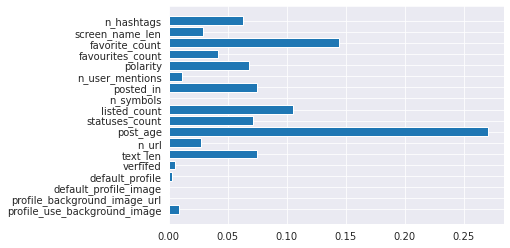

In [143]:
importance = dt_user.feature_importances_
cols = X.columns

for i,v in enumerate(importance):
    print('{}, Score: {:.5f}'.format(cols[i],v))
# plot feature importance
plt.barh([x for x in cols], importance)
plt.show()

# Rumor text model

In [45]:
!pwd

/content


In [46]:
%cd /content/drive/MyDrive/Rumor Detection/PWD

/content/drive/MyDrive/Rumor Detection/PWD


In [47]:
!ls -l

total 2206142
-rw------- 1 root root 2259088777 Jun 20 18:11 wiki-news-300d-1M.vec


In [48]:
!pip install tweet-preprocessor
!pip install wordsegment
!pip install contractions

     |████████████████████████████████| 4.8MB 28.2MB/s 
     |████████████████████████████████| 286kB 30.4MB/s 
     |████████████████████████████████| 327kB 45.6MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85402 sha256=7cd87af114690b49d529a1f0b9f15deee050729266570ff6c51dd527b5c7b5f3
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [49]:
db = pd.read_csv('/content/drive/MyDrive/Rumor Detection/new Dataset/train/tweet (1).csv')

In [50]:
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
stop_list = stopwords.words('english')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
import os, re, csv, math, codecs


# For Training
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
#from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

# For array, dataset, and visualizing
import numpy as np
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')

import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import STOPWORDS,WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata


from keras.preprocessing import text,sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Embedding
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [51]:
def tt_preprocess(db):
  
  data=[db['text'],db['text'].apply(len),db['label']]
  headers=["text","length","target"]
  text_df=pd.concat(data,axis=1,keys=headers)
  text_df['target']=text_df['target'].astype(int)
  text_df['clean_tweet']=''
  import preprocessor as p
  def word_abbrev(word):
      return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word
    
  def replace_abbrev(text):
      string = ""
      for word in text.split():
          string += word_abbrev(word) + " "        
      return string
  abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "f*ck" : "fuck",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}
  #removing link, reserved word, emoji,smiley,number

  p.set_options(p.OPT.URL
  ,p.OPT.RESERVED
  ,p.OPT.EMOJI
  ,p.OPT.SMILEY
  ,p.OPT.NUMBER)

  for index,row in text_df.iterrows():
    text_df['clean_tweet'][index] = p.clean(text_df['text'][index])
  from wordsegment import load,segment

  # Removing contractions

  import contractions
  for index,row in text_df.iterrows():
    expanded_words = []
    for word in text_df['clean_tweet'][index].split():
      expanded_words.append(contractions.fix(word))
    expanded_text = ' '.join(expanded_words)
    text_df['clean_tweet'][index]=expanded_text

  # Replace abbreviations

  for index,row in text_df.iterrows():
    text_df['clean_tweet'][index] = replace_abbrev(text_df['clean_tweet'][index])

  # removing hashtags, mentions, splitting hashtags
  load()
  for index,row in text_df.iterrows():
    text_df['clean_tweet'][index] = ' '.join(segment(text_df['clean_tweet'][index]))

  ####

  stop_words = set(stopwords.words('english'))
  stop_words.add('k')
  # removing stop words

  for index,row in text_df.iterrows():
    text_df['clean_tweet'][index] = ' '.join([word for word in text_df['clean_tweet'][index].split() if word not in (stop_words)])

  return text_df


In [52]:
from sklearn.model_selection import train_test_split

In [53]:
db['label']=db['label'].replace(['unverified'],True)
db['label']=db['label'].replace(['non-rumor'],False)
db['label']=db['label'].replace(['true'],True)
db['label']=db['label'].replace(['false'],True)

In [54]:
text_df = tt_preprocess(db)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:272: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:277: SettingWithCopyWarning: 
A value is trying 

In [55]:
text_df

,text,length,target,clean_tweet
0,Ten dead in shooting at Paris offices of satir...,111,1,ten dead shooting paris offices satirical maga...
1,Pop legend Prince has died at 57: https://t.co...,81,0,pop legend prince died
2,"Will you be able to float on Jan. 4, 2015, aka...",117,1,able float january aka zero g day hint
3,"Gunfire, explosions heard at print plant north...",140,0,gunfire explosions heard print plant north par...
4,"Alaskan reporter says ""f*ck this,"" quits on li...",132,1,alaskan reporter says fck quits live tv mariju...
...,...,...,...,...
5872,#Breaking: Soldier killed at war memorial iden...,137,1,breaking soldier killed war memorial identifie...
5873,Statement from Ottawa Hospital: received 3 pat...,98,1,statement ottawa hospital received patients st...
5874,Corporations have sold or spun off $1.6 trilli...,143,1,corporations sold spun 16 trillion worth subsi...
5875,Justice must be served! #Ferguson #MikeBrown,45,0,justice must served ferguson mike brown


In [56]:
text_df.shape[0]

5877

In [57]:
def further_process_1(text_df):
  import numpy as np
  raw_docs = text_df['clean_tweet'].tolist()
  text_df['clean_len']=''
  text_df['clean_len']=text_df['clean_tweet'].apply(len)
  max_seq_len = np.round(text_df['clean_len'].mean()+text_df['clean_len'].std()).astype(int)
  MAX_NB_WORDS=100000
  embed_dim = 300
  tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
  tokenizer.fit_on_texts(text_df['clean_tweet'])  #leaky
  word_seq = tokenizer.texts_to_sequences(raw_docs)
  word_index = tokenizer.word_index
  print("dictionary size: ", len(word_index))

  #pad sequences
  word_seq = sequence.pad_sequences(word_seq, maxlen=max_seq_len)
  return word_seq

In [58]:

word_seq = further_process_1(text_df)

dictionary size:  9083


In [59]:
from tensorflow.keras.models import load_model
rumor_text = load_model('/content/drive/MyDrive/Rumor Detection/models/all_models/rumor_text_v2.h5')

In [60]:
rumor_text.evaluate(word_seq,text_df['target'])

184/184 [==============================] - 26s 122ms/step - loss: 0.4011 - accuracy: 0.8079


[0.4011484980583191, 0.8078951835632324]

In [61]:
rumor_text_probs = rumor_text.predict_proba(word_seq)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [62]:
fake_real = load_model('/content/drive/MyDrive/Rumor Detection/models/all_models/fake_real_text.h5')

In [63]:
fake_real_probs = fake_real.predict_proba(word_seq)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [64]:
fake_real_probs.shape

(5877, 1)

# Reaction Model

In [4]:
reaction = pd.read_csv('/content/drive/MyDrive/Rumor Detection/new Dataset/clean_reaction.csv').drop('Unnamed: 0', axis=1)
reaction.head()

,tweetId,text,retweet_count,favorite_count,label,sentiments,n_hashtag
0,552784600502915072,"['dead', 'shooting', 'today', 'rt', 'charlie',...",0,0,non-rumours,-0.200000,0
1,552784600502915072,"['im', 'guessing', 'considered', 'terrorism', ...",0,0,non-rumours,0.285714,0
2,552784600502915072,"['would', 'mention', 'knowing', 'fact']",1,0,non-rumours,0.000000,1
3,552784600502915072,"['perps', 'identified']",0,0,non-rumours,0.000000,0
4,552784600502915072,"['charlie', 'hebdo']",0,0,non-rumours,0.000000,0


In [5]:
len(tweet.merge(reaction, on='tweetId'))

68653

In [6]:
def reaction_preprocessing(tweets):

  def weighted_sentiments_avg(tweet, df, weight_col, colname):
    tweet[colname+"_weighted_polarity"] = tweet['sentiments']*weight_col
    x  = pd.DataFrame(tweet.groupby('tweetId')[colname+"_weighted_polarity"].mean())
    # df = df.merge(x, left_index=True, right_index=True)
    return x

  labels = pd.DataFrame(columns=['tweetId', 'label'])

  for id in tweets['tweetId'].unique():
    label = tweets[tweets['tweetId'] == id]['label'].unique()[0]
    labels.loc[len(labels.index)] = [id, label]

  labels = labels.set_index('tweetId')
  labels.head()

  avg = tweets.groupby('tweetId').mean()
  df = pd.DataFrame(avg)

  df = df.merge(labels, left_index=True, right_index=True)

  x = weighted_sentiments_avg(tweets.copy(), df, tweets['favorite_count'] , 'favorite')
  df = df.merge(x, left_index=True, right_index=True)

  x = weighted_sentiments_avg(tweets.copy(), df, tweets['retweet_count'] , 'retweet')
  df = df.merge(x, left_index=True, right_index=True)

  x = weighted_sentiments_avg(tweets.copy(), df, tweets['retweet_count']+tweets['favorite_count'] , 'favorite_retweet')
  df = df.merge(x, left_index=True, right_index=True)

  df['label'] = df['label'].replace({'non-rumours':False, 'rumours':True})
  df['label'] = df['label'].astype(np.int64)
  df[['retweet_count', 'favorite_count' ,'favorite_weighted_polarity', 'n_hashtag',
      'sentiments', 'retweet_weighted_polarity', 'favorite_retweet_weighted_polarity'] ] = df[['retweet_count', 'favorite_count' ,'favorite_weighted_polarity', 'n_hashtag',
                                                                          'sentiments', 'retweet_weighted_polarity', 'favorite_retweet_weighted_polarity'] ].astype(np.int64)
    
  return df

In [7]:
x_reaction = reaction_preprocessing(reaction.copy())
x_reaction.head()

,retweet_count,favorite_count,sentiments,n_hashtag,label,favorite_weighted_polarity,retweet_weighted_polarity,favorite_retweet_weighted_polarity
tweetId,,,,,,,,
498235547685756928,17,9,0,0,0,0,0,0
498248415223246848,0,0,0,0,0,0,0,0
498248648699150336,13,2,0,0,0,0,1,2
498250100079341568,0,0,0,0,0,0,0,0
498251940997136384,19,1,0,0,0,0,4,4


In [29]:
x_reaction.shape

(5748, 8)

In [8]:
import tensorflow as tf
reaction_model = tf.keras.models.load_model('/content/drive/MyDrive/Rumor Detection/models/all_models/reaction_model.h5')
sel_features = ['retweet_count', 'favorite_count' ,'favorite_weighted_polarity', 'n_hashtag',
      'sentiments', 'retweet_weighted_polarity', 'favorite_retweet_weighted_polarity']

In [15]:
reaction_tweet = tweet.merge(x_reaction, on='tweetId', how="inner", suffixes=['_t', '_r'])[['retweet_count_r', 'favorite_count_r' ,'favorite_weighted_polarity', 'n_hashtag',
      'sentiments', 'retweet_weighted_polarity', 'favorite_retweet_weighted_polarity','label_t']]
reaction_tweet.shape

(4101, 8)

In [21]:
x_react = reaction_tweet.drop('label_t', axis=1)
y_react = reaction_tweet['label_t'].replace({'non-rumor':False, 'true':True, 'false':True, 'unverified':True})
y_react = y_react.astype(np.int64)
y_react

0       1
1       0
2       0
3       1
4       0
       ..
4096    0
4097    0
4098    1
4099    1
4100    0
Name: label_t, Length: 4101, dtype: int64

In [22]:
reaction_model.evaluate(x_react, y_react)

129/129 [==============================] - 1s 982us/step - loss: 0.8219 - acc: 0.6194


[0.8218637704849243, 0.6193611025810242]

In [9]:
for idx, data in x_reaction.iterrows():
  # print(idx)
  # print(data)
  x_reaction.loc[idx, 'predict_proba'] = reaction_model.predict_proba(data[sel_features].to_numpy().reshape(1,-1))[0][0]
  #print( reaction_model.predict_proba(data[['retweet_count', 'favorite_count' ,'favorite_weighted_polarity', 'n_hashtag','sentiments', 'retweet_weighted_polarity', 'favorite_retweet_weighted_polarity']].to_numpy().reshape(1. -1)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [65]:
x_reaction = x_reaction.reset_index(level=0)

In [66]:
len(tweet.merge(x_reaction, on='tweetId'))

4101

In [67]:
x_reaction.head()

,tweetId,retweet_count,favorite_count,sentiments,n_hashtag,label,favorite_weighted_polarity,retweet_weighted_polarity,favorite_retweet_weighted_polarity,predict_proba
0,498235547685756928,17,9,0,0,0,0,0,0,0.001655
1,498248415223246848,0,0,0,0,0,0,0,0,0.335949
2,498248648699150336,13,2,0,0,0,0,1,2,0.015397
3,498250100079341568,0,0,0,0,0,0,0,0,0.335949
4,498251940997136384,19,1,0,0,0,0,4,4,0.006753


In [68]:
reaction_predict_proba = pd.DataFrame(columns=['tweetId', 'Predict_proba'])

for idx, data in tweet.iterrows():
  id = data['tweetId']
  pred = 0.5
  if id in x_reaction['tweetId'].to_numpy():
    pred = x_reaction[x_reaction['tweetId'] == id]['predict_proba'].to_numpy()[0]
    # print(pred)
    # break

  reaction_predict_proba.loc[len(reaction_predict_proba.index)] = [id, pred]

In [69]:
reaction_predict_proba

,tweetId,Predict_proba
0,5.527901e+17,0.335949
1,7.231984e+17,0.500000
2,5.478033e+17,0.500000
3,5.535843e+17,0.335949
4,5.140570e+17,0.500000
...,...,...
5872,5.250203e+17,0.091780
5873,5.249724e+17,0.335949
5874,5.193111e+17,0.500000
5875,5.000709e+17,0.500000


# Combine all models

In [70]:
# for m in [fake_real_probs,rumor_text_probs,user_tweet_prob,reaction_predict_proba['Predict_proba'].to_numpy().res]:
#   print(m.shape)


AttributeError: ignored

In [71]:
comb_array = np.concatenate((fake_real_probs,rumor_text_probs,user_tweet_prob,reaction_predict_proba['Predict_proba'].to_numpy().reshape(-1,1) ),axis=1)


In [72]:
comb_array

array([[1.88648701e-04, 9.80781436e-01, 6.75751507e-01, 3.35948855e-01],
       [4.87286985e-01, 8.87524724e-01, 2.87675858e-03, 5.00000000e-01],
       [9.99808192e-01, 2.52834171e-01, 4.38835144e-01, 5.00000000e-01],
       ...,
       [2.68577933e-01, 8.92913938e-02, 8.33206654e-01, 5.00000000e-01],
       [2.84499228e-02, 3.21531296e-03, 2.31830657e-01, 5.00000000e-01],
       [8.47973347e-01, 6.82016253e-01, 7.82286763e-01, 1.05363816e-01]])

In [73]:
combine_df = pd.DataFrame(comb_array, columns = ['fake_real','rumor_text','user_tweet', 'reaction'])

In [74]:
combine_df.head()

,fake_real,rumor_text,user_tweet,reaction
0,0.000189,0.980781,0.675752,0.335949
1,0.487287,0.887525,0.002877,0.500000
2,0.999808,0.252834,0.438835,0.500000
3,0.082869,0.180600,0.584348,0.335949
4,0.073805,0.786869,0.953712,0.500000


In [75]:
combine_df['target'] = text_df['target']

In [76]:
combine_df.head()

,fake_real,rumor_text,user_tweet,reaction,target
0,0.000189,0.980781,0.675752,0.335949,1
1,0.487287,0.887525,0.002877,0.500000,0
2,0.999808,0.252834,0.438835,0.500000,1
3,0.082869,0.180600,0.584348,0.335949,0
4,0.073805,0.786869,0.953712,0.500000,1


In [77]:
X_train,X_test,y_train,y_test = train_test_split(combine_df.drop('target',axis=1),combine_df['target'],test_size=0.2,random_state=42,stratify=combine_df['target'])

In [78]:
X_train.head()

,fake_real,rumor_text,user_tweet,reaction
2828,0.081521,0.102350,0.622984,0.335949
5375,0.007073,0.507191,0.258673,0.335949
1771,0.197439,0.835392,0.788860,0.500000
5203,0.950452,0.465824,0.896043,0.500000
2585,0.000078,0.847624,0.152626,0.335949


## Multiple models for models

In [103]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [104]:
metrics = pd.DataFrame(columns=['model' ,'f1 score', 'train accuracy','test accuracy'])

In [105]:
random_state = 42
models=[
        XGBClassifier(max_depth=6, n_estimators=1000),
        LogisticRegression(random_state=random_state),
        SVC(random_state=random_state),
        MultinomialNB(),
        DecisionTreeClassifier(random_state = random_state),
        KNeighborsClassifier(),
        RandomForestClassifier(random_state=random_state),
       ]

In [106]:
from matplotlib import pyplot as plt
import seaborn as sns
def fit_and_predict(model,x_train,x_test,y_train,y_test):
    classifier = model
    classifier_name = str(classifier.__class__.__name__)

    classifier.fit(x_train,y_train)

    y_pred = classifier.predict(x_test)
    cmatrix = confusion_matrix(y_test,y_pred)


    f,ax = plt.subplots(figsize=(3,3))
    sns.heatmap(cmatrix,annot=True,linewidths=0.5,cbar=False,linecolor="red",fmt='.0f',ax=ax)
    plt.xlabel("y_predict")
    plt.ylabel("y_true")
    ax.set(title=str(model))
    plt.show()


    f1score = f1_score(y_test,y_pred,average='weighted')
    train_accuracy = round(classifier.score(x_train,y_train)*100)
    test_accuracy =  round(accuracy_score(y_test,y_pred)*100)

    global metrics
    metrics = metrics.append({
                              'model': classifier_name,
                              'f1 score': f1score, 
                              'train accuracy': train_accuracy, 
                              'test accuracy': test_accuracy, 
                             },
                               ignore_index=True
                            )

    print(classification_report(y_test,y_pred))    
    print('Accuracy of classifier on training set:{}%'.format(train_accuracy))
    print('Accuracy of classifier on test set:{}%' .format(test_accuracy))

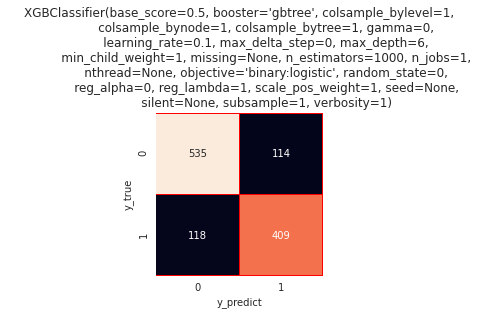

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       649
           1       0.78      0.78      0.78       527

    accuracy                           0.80      1176
   macro avg       0.80      0.80      0.80      1176
weighted avg       0.80      0.80      0.80      1176

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:80%


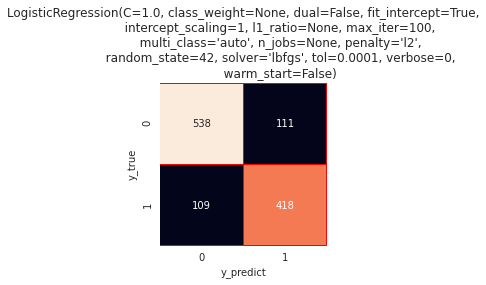

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       649
           1       0.79      0.79      0.79       527

    accuracy                           0.81      1176
   macro avg       0.81      0.81      0.81      1176
weighted avg       0.81      0.81      0.81      1176

Accuracy of classifier on training set:88%
Accuracy of classifier on test set:81%


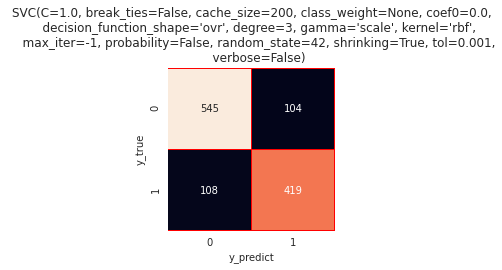

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       649
           1       0.80      0.80      0.80       527

    accuracy                           0.82      1176
   macro avg       0.82      0.82      0.82      1176
weighted avg       0.82      0.82      0.82      1176

Accuracy of classifier on training set:89%
Accuracy of classifier on test set:82%


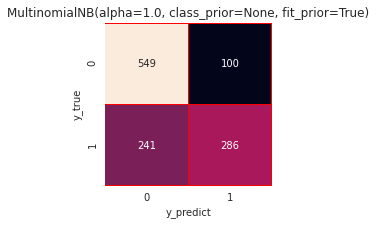

              precision    recall  f1-score   support

           0       0.69      0.85      0.76       649
           1       0.74      0.54      0.63       527

    accuracy                           0.71      1176
   macro avg       0.72      0.69      0.69      1176
weighted avg       0.72      0.71      0.70      1176

Accuracy of classifier on training set:76%
Accuracy of classifier on test set:71%


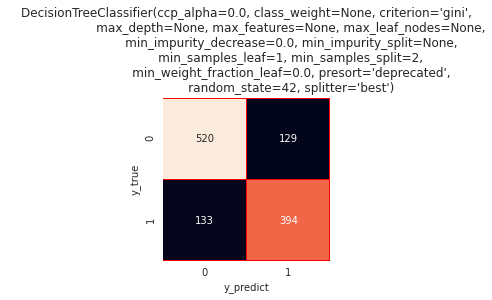

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       649
           1       0.75      0.75      0.75       527

    accuracy                           0.78      1176
   macro avg       0.77      0.77      0.77      1176
weighted avg       0.78      0.78      0.78      1176

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:78%


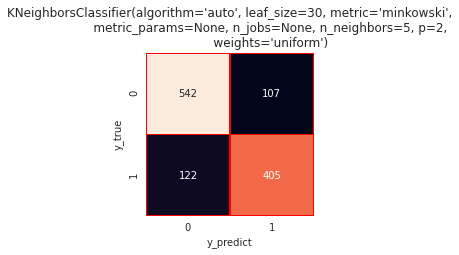

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       649
           1       0.79      0.77      0.78       527

    accuracy                           0.81      1176
   macro avg       0.80      0.80      0.80      1176
weighted avg       0.80      0.81      0.80      1176

Accuracy of classifier on training set:91%
Accuracy of classifier on test set:81%


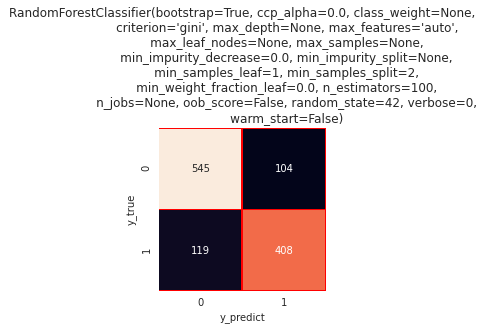

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       649
           1       0.80      0.77      0.79       527

    accuracy                           0.81      1176
   macro avg       0.81      0.81      0.81      1176
weighted avg       0.81      0.81      0.81      1176

Accuracy of classifier on training set:100%
Accuracy of classifier on test set:81%


In [107]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import sklearn.metrics as metric
for model in models:
  fit_and_predict(model,X_train,X_test,y_train,y_test)

## Neural network

In [79]:
from keras.layers import Dense, Activation,Embedding,Flatten,LeakyReLU,BatchNormalization,Dropout
from keras.activations import relu,sigmoid
from keras.layers import LeakyReLU

from keras.models import Sequential
from keras.layers import Dense

from keras.regularizers import l2
import tensorflow as tf

In [80]:

model2 = Sequential()
model2.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(64,activation='relu',))
model2.add(Dropout(0.3))
model2.add(Dense(1,kernel_initializer='glorot_uniform',activation='sigmoid'))
model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [81]:
!pip install livelossplot
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor='val_loss', patience=10,mode='min')
callbacks = [PlotLossesKeras(), es_callback]


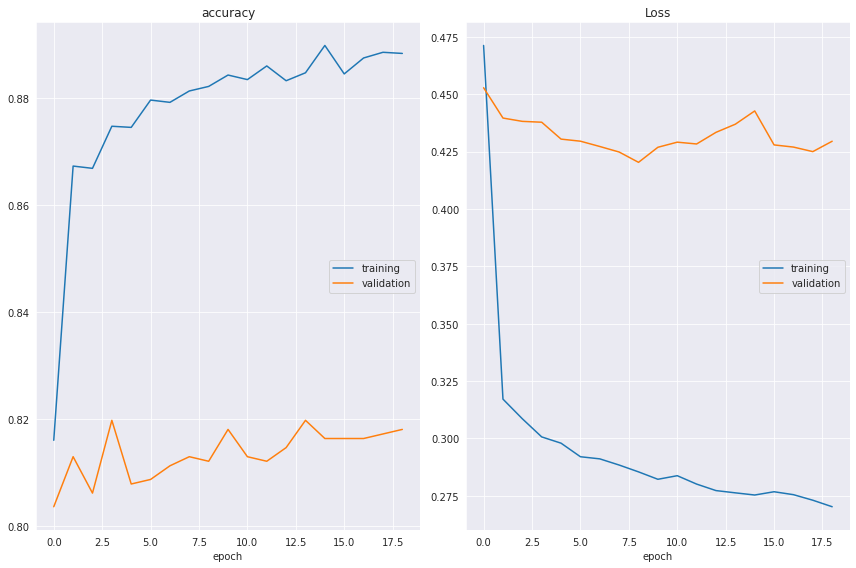

accuracy
	training         	 (min:    0.816, max:    0.890, cur:    0.888)
	validation       	 (min:    0.804, max:    0.820, cur:    0.818)
Loss
	training         	 (min:    0.270, max:    0.471, cur:    0.270)
	validation       	 (min:    0.420, max:    0.453, cur:    0.430)


In [82]:
model2.fit(X_train,y_train,epochs=150,batch_size=32,validation_data=(X_test,y_test),callbacks=callbacks)

In [97]:
layer_0 = model2.layers[0]
np.array(layer_0.get_weights()[0]).shape

(4, 64)

In [105]:
X_train

,fake_real,rumor_text,user_tweet,reaction
2828,0.081521,0.102350,0.622984,0.335949
5375,0.007073,0.507191,0.258673,0.335949
1771,0.197439,0.835392,0.788860,0.500000
5203,0.950452,0.465824,0.896043,0.500000
2585,0.000078,0.847624,0.152626,0.335949
...,...,...,...,...
1246,0.797511,0.231008,0.002247,0.500000
76,0.000088,0.007091,0.016544,0.146947
1097,0.000142,0.323743,0.042640,0.500000
3705,0.000124,0.474492,0.692493,0.146947


In [112]:
from scipy.stats import pointbiserialr

corr = {}
for col in X_train.columns:
  corr[col] = pointbiserialr(X_train[col], y_train)
                             
corr_df = pd.DataFrame(corr, index=['correlation', 'pvalue'])
corr_df

,fake_real,rumor_text,user_tweet,reaction
correlation,0.048921,0.724099,0.687885,2.166168e-01
pvalue,0.000793,0.000000,0.000000,4.894834e-51


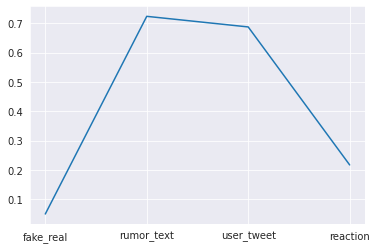

In [129]:
plt.plot(corr_df.loc['correlation', :])

In [84]:
model2.save('/content/drive/MyDrive/Rumor Detection/models/all_models')

In [115]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [117]:
importance = dt.feature_importances_
importance

array([0.08483973, 0.58762647, 0.27067315, 0.05686066])

Feature: 0, Score: 0.08484
Feature: 1, Score: 0.58763
Feature: 2, Score: 0.27067
Feature: 3, Score: 0.05686


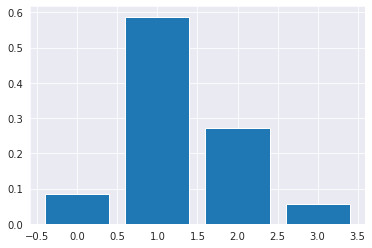

In [119]:
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

#Test set



In [23]:
test_tweet = pd.read_csv('/content/drive/MyDrive/Rumor Detection/new Dataset/test/tweet.csv')
test_user = pd.read_csv('/content/drive/MyDrive/Rumor Detection/new Dataset/test/user.csv')

In [24]:
test_tweet['label']=test_tweet['label'].replace(['unverified'],True)
test_tweet['label']=test_tweet['label'].replace(['non-rumor'],False)
test_tweet['label']=test_tweet['label'].replace(['true'],True)
test_tweet['label']=test_tweet['label'].replace(['false'],True)

In [114]:
txt_df = tt_preprocess(test_tweet)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:272: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:277: SettingWithCopyWarning: 
A value is trying 

In [115]:
txt_df.shape[0]

1038

In [116]:
test_word_seq = further_process_1(txt_df)

dictionary size:  3607


In [117]:
rumor_text.evaluate(test_word_seq,txt_df['target'])

33/33 [==============================] - 4s 115ms/step - loss: 0.8717 - accuracy: 0.5867


[0.871718168258667, 0.586705207824707]

In [118]:
test_rumor_probs = rumor_text.predict_proba(test_word_seq)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [121]:
test_X,test_y = meta_data_preprocessing(test_tweet,test_user)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [122]:
user_tweet_model.evaluate(test_X,test_y,verbose=2)

33/33 - 0s - loss: 0.5514 - accuracy: 0.7129


[0.5513978004455566, 0.712909460067749]

In [123]:
test_user_tweet_probs = user_tweet_model.predict_proba(test_X)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [124]:
text_fr_probs = fake_real.predict_proba(test_word_seq)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [25]:
test_reaction_tweet = test_tweet.merge(x_reaction, on='tweetId', how="inner", suffixes=['_t', '_r'])[['retweet_count_r', 'favorite_count_r' ,'favorite_weighted_polarity', 'n_hashtag',
      'sentiments', 'retweet_weighted_polarity', 'favorite_retweet_weighted_polarity','label_t']]
test_reaction_tweet.shape

(720, 8)

In [27]:
test_x_react = test_reaction_tweet.drop('label_t', axis=1)
test_y_react = test_reaction_tweet['label_t']
y_react

0       1
1       0
2       0
3       1
4       0
       ..
4096    0
4097    0
4098    1
4099    1
4100    0
Name: label_t, Length: 4101, dtype: int64

In [28]:
comment_res = reaction_model.evaluate(test_x_react, test_y_react )

23/23 [==============================] - 0s 1ms/step - loss: 0.8240 - acc: 0.6417


In [132]:
test_reaction_predict_proba = pd.DataFrame(columns=['tweetId', 'Predict_proba'])

for idx, data in test_tweet.iterrows():
  id = data['tweetId']
  pred = 0.5
  if id in x_reaction['tweetId'].to_numpy():
    pred = x_reaction[x_reaction['tweetId'] == id]['predict_proba'].to_numpy()[0]
    # print(pred)
    # break

  test_reaction_predict_proba.loc[len(test_reaction_predict_proba.index)] = [id, pred]

In [133]:
test_reaction_predict_proba

,tweetId,Predict_proba
0,5.003785e+17,0.062246
1,5.766001e+17,0.146947
2,4.982355e+17,0.001655
3,5.528188e+17,0.097661
4,5.444597e+17,0.335949
...,...,...
1033,5.528169e+17,0.335949
1034,5.368120e+17,0.500000
1035,5.531176e+17,0.000003
1036,4.982844e+17,0.090579


In [134]:
for m in [text_fr_probs,test_rumor_probs,test_user_tweet_probs,test_reaction_predict_proba['Predict_proba'].to_numpy().reshape(-1,1)]:
  print(m.shape)

(1038, 1)
(1038, 1)
(1038, 1)
(1038, 1)


In [135]:
test_comb_array = np.concatenate((text_fr_probs,test_rumor_probs,test_user_tweet_probs,test_reaction_predict_proba['Predict_proba'].to_numpy().reshape(-1,1)),axis=1)


In [137]:
test_combine_df = pd.DataFrame(test_comb_array, columns = ['fake_real','rumor_text','user_tweet', 'reaction'])

In [138]:
test_combine_df

,fake_real,rumor_text,user_tweet,reaction
0,0.126247,0.551157,0.815858,0.062246
1,0.023485,0.324689,0.848702,0.146947
2,0.118860,0.227427,0.338617,0.001655
3,0.486649,0.313957,0.186649,0.097661
4,0.041573,0.961461,0.392280,0.335949
...,...,...,...,...
1033,0.890392,0.004344,0.043783,0.335949
1034,0.010492,0.734506,0.959410,0.500000
1035,0.000538,0.966253,0.156447,0.000003
1036,0.000110,0.780495,0.607813,0.090579


In [139]:
model2.evaluate(test_combine_df,txt_df['target'])

33/33 [==============================] - 0s 1ms/step - loss: 0.6533 - accuracy: 0.7081


[0.6532662510871887, 0.7080925107002258]